In [1]:
import numpy as np
import h5py
import matplotlib
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
import sys
from PIL import Image
sys.path.append('../')
from utils.common_fcns import *
np.set_printoptions(threshold=sys.maxsize)

/home/alex/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
# Quantized K-Wavelet compression

def quantize(X):
    Xmax = np.max(X)
    X_q = X*255/Xmax
    X_q = np.array(X_q, dtype=np.int8)
    return X_q

In [3]:
# Load a scan in
data_dir = '../data/multicoil_test/'
file = data_dir+'file_brain_AXT2_200_2000482.h5'
hf = h5py.File(file)
volume_kspace = hf['kspace'][()]
n_slices = volume_kspace.shape[0]
print('Number of Slices for this file: '+str(n_slices))

Number of Slices for this file: 16


In [4]:
# Pick a slice for our tests
X_raw = combine_all_coils(volume_kspace,8)
X = resize_scan(X_raw)

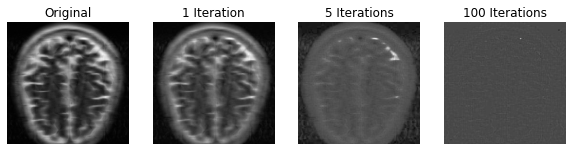

In [72]:
# Illustrating how bad jpeg is, here's perfoming it 3x recursively
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(10, 5)

X_recursive = X
ax1.imshow(np.abs(X_recursive), cmap='gray')
ax1.set_title('Original')
ax1.set_axis_off()

X_recursive = X
for ii in range(1):
    X_recursive = to_jpeg(X_recursive,X)
    ax2.imshow(np.abs(X_recursive), cmap='gray')
    ax2.set_title('1 Iteration')
    ax2.set_axis_off()
X_recursive = X
for ii in range(5):
    X_recursive = to_jpeg(X_recursive,X)
    ax3.imshow(np.abs(X_recursive), cmap='gray')
    ax3.set_title('5 Iterations')
    ax3.set_axis_off()

X_recursive = X
error = np.zeros(101)
error[0] = frob_error(X,X)
for ii in range(100):
    X_recursive = to_jpeg(X_recursive,X)
    ax4.imshow(np.abs(X_recursive), cmap='gray')
    ax4.set_title('100 Iterations')
    ax4.set_axis_off()
    error[ii+1] = frob_error(X,X_recursive)

fig.savefig('../images/jpeg_recursion.png', dpi=100)

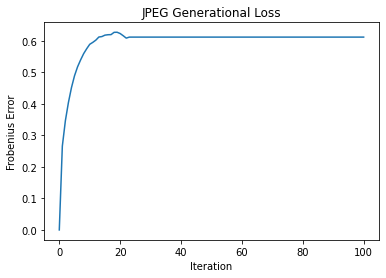

<Figure size 432x288 with 0 Axes>

In [74]:
plt.plot(np.arange(101), error)
plt.xlabel('Iteration')
plt.ylabel('Frobenius Error')
plt.title('JPEG Generational Loss')
plt.show()
plt.savefig('../images/JPEG_generational_loss_plot.png', dpi=100)

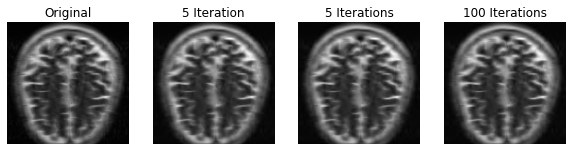

In [76]:
# Compare to how un-quantized k-wavelet reconstruction looks
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(10, 5)

X_recursive = X
ax1.imshow(np.abs(X_recursive), cmap='gray')
ax1.set_title('Original')
ax1.set_axis_off()

X_recursive = X
for ii in range(1):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax2.imshow(np.abs(X_recursive), cmap='gray')
    ax2.set_title('5 Iteration')
    ax2.set_axis_off()

X_recursive = X
for ii in range(5):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax3.imshow(np.abs(X_recursive), cmap='gray')
    ax3.set_title('5 Iterations')
    ax3.set_axis_off()

X_recursive = X
error = np.zeros(101)
error[0] = frob_error(X,X)
for ii in range(100):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax4.imshow(np.abs(X_recursive), cmap='gray')
    ax4.set_title('100 Iterations')
    ax4.set_axis_off()
    error[ii+1] = frob_error(X,X_recursive)

fig.savefig('../images/k_wavelet_recursion.png', dpi=100)

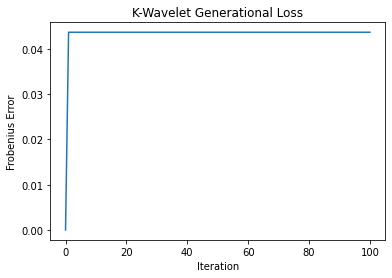

<Figure size 432x288 with 0 Axes>

In [77]:
plt.plot(np.arange(101), error)
plt.xlabel('Iteration')
plt.ylabel('Frobenius Error')
plt.title('K-Wavelet Generational Loss')
plt.show()
plt.savefig('../images/k_wavelet_generational_loss_plot.png', dpi=100)

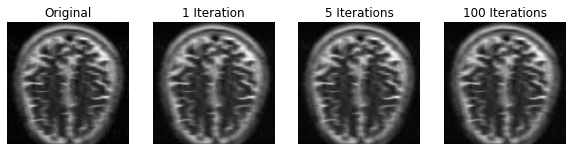

In [78]:
# Compare to how 8-bit quantized k-wavelet reconstruction looks
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(10, 5)

X_recursive = X
ax1.imshow(np.abs(X_recursive), cmap='gray')
ax1.set_title('Original')
ax1.set_axis_off()

X_recursize = quantize(X)
for ii in range(1):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax2.imshow(np.abs(X_recursive), cmap='gray')
    ax2.set_title('1 Iteration')
    ax2.set_axis_off()

X_recursize = quantize(X)
for ii in range(5):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax3.imshow(np.abs(X_recursive), cmap='gray')
    ax3.set_title('5 Iterations')
    ax3.set_axis_off()

X_recursize = quantize(X)
error = np.zeros(101)
error[0] = frob_error(X,X)
for ii in range(100):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax4.imshow(np.abs(X_recursive), cmap='gray')
    ax4.set_title('100 Iterations')
    ax4.set_axis_off()
    error[ii+1] = frob_error(X,X_recursive)

fig.savefig('../images/quantized_k_wavelet_recursion.png', dpi=100)

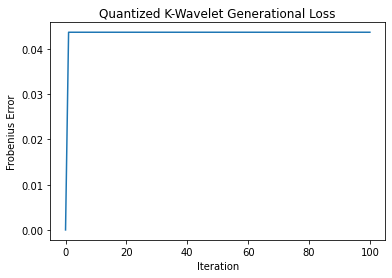

<Figure size 432x288 with 0 Axes>

In [80]:
plt.plot(np.arange(101), error)
plt.xlabel('Iteration')
plt.ylabel('Frobenius Error')
plt.title('Quantized K-Wavelet Generational Loss')
plt.show()
plt.savefig('../images/quantized_k_wavelet_generational_loss_plot.png', dpi=100)